In [2]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
# open pickled files
stationfile = open('data_cleaned/stations_all_data', mode = 'rb')
weatherfile = open('data_cleaned/weathers_all_data', mode = 'rb')
tripfile = open('data_cleaned/trips_all_data', mode = 'rb')
statusfile1 = open('data_cleaned/status_all_data1', mode= 'rb')
statusfile2 = open('data_cleaned/status_all_data2', mode= 'rb')
statusfile3 = open('data_cleaned/status_all_data3', mode= 'rb')

# load pickled files to dataframe objects
stations = pickle.load(stationfile)
weathers = pickle.load(weatherfile)
trips = pickle.load(tripfile)
status1 = pickle.load(statusfile1)
status2 = pickle.load(statusfile2)
status3 = pickle.load(statusfile3)

# Merge 3 partitions of status data
status = pd.concat([status1, status2, status3])

# Number of Trips
How many trips per month, week and day since BikeShare launched? Let's check it out!

## Number of trips per month

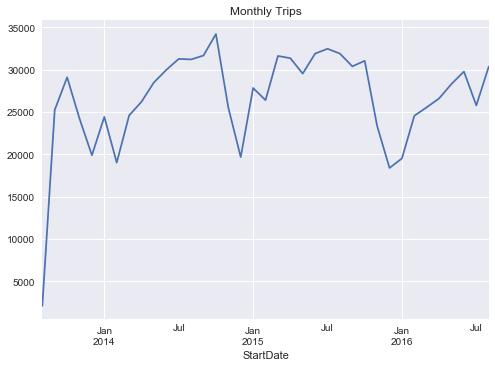

In [40]:
numTrip = trips.set_index('StartDate')
numTrip = numTrip.groupby(pd.TimeGrouper(freq = 'M')).size()
numTrip = numTrip.sort_index()
numTrip.plot(title = 'Monthly Trips')


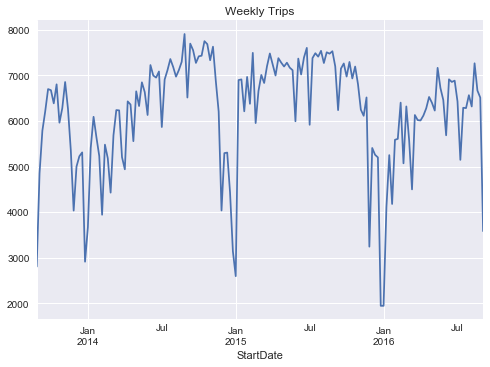

In [39]:
numTrip = trips.set_index('StartDate')
numTrip = numTrip.groupby(pd.TimeGrouper(freq = 'w')).size()
numTrip = numTrip.sort_index()
numTrip.plot(title = 'Weekly Trips');

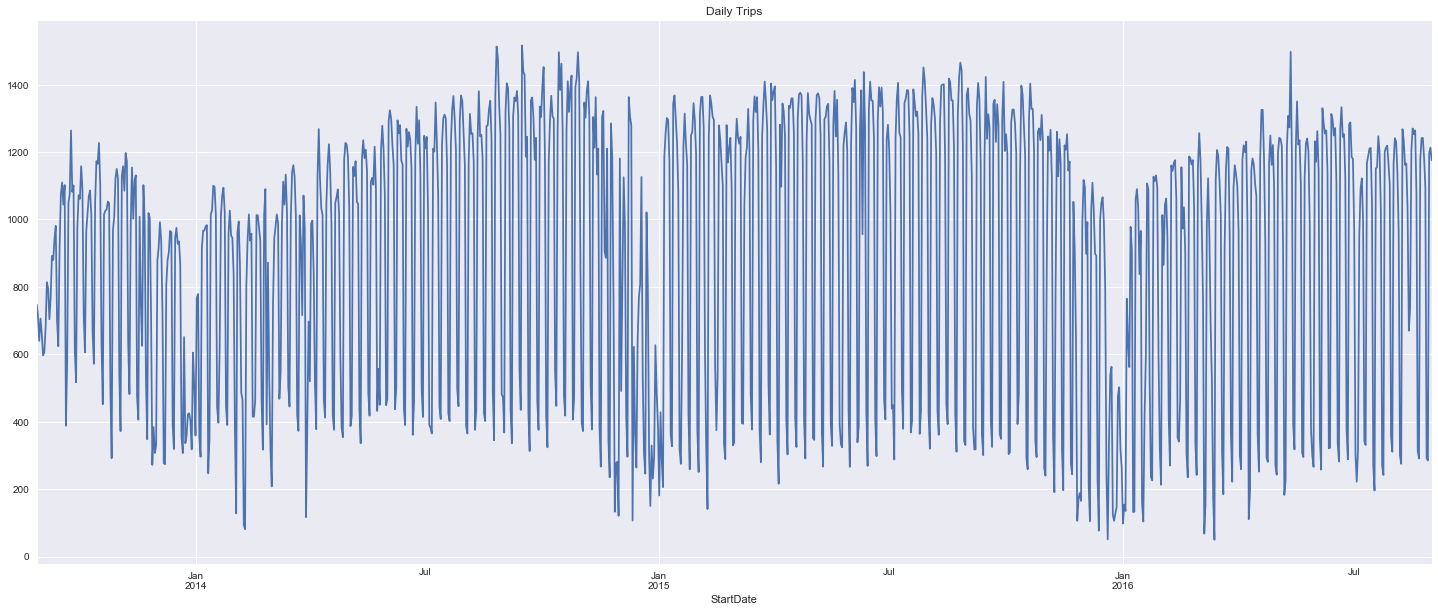

In [38]:
numTrip = trips.set_index('StartDate')
numTrip = numTrip.groupby(pd.TimeGrouper(freq = 'D')).size()
numTrip = numTrip.sort_index()
numTrip.plot(title = 'Daily Trips', figsize=(25,10));

## Unique bikes used per day

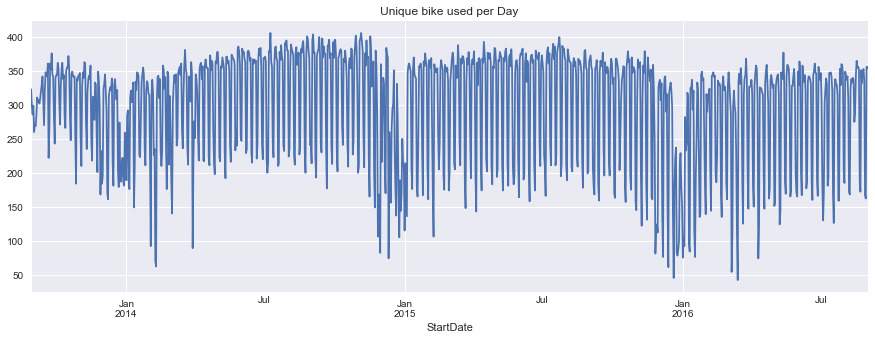

In [41]:
uniqueBike = trips.set_index('StartDate')
uniqueBike = uniqueBike.groupby(pd.TimeGrouper(freq = 'D'))['Bike#'].nunique()
uniqueBike.plot(title = 'Unique bike used per Day', figsize = (15,5));

## Bikes usage in weekdays

In [47]:
# Import calendar from pandas
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start = trips['StartDate'].min(), end = trips['StartDate'].max())

In [55]:
worktrips.index.date.isin(holidays) == False

AttributeError: 'numpy.ndarray' object has no attribute 'isin'

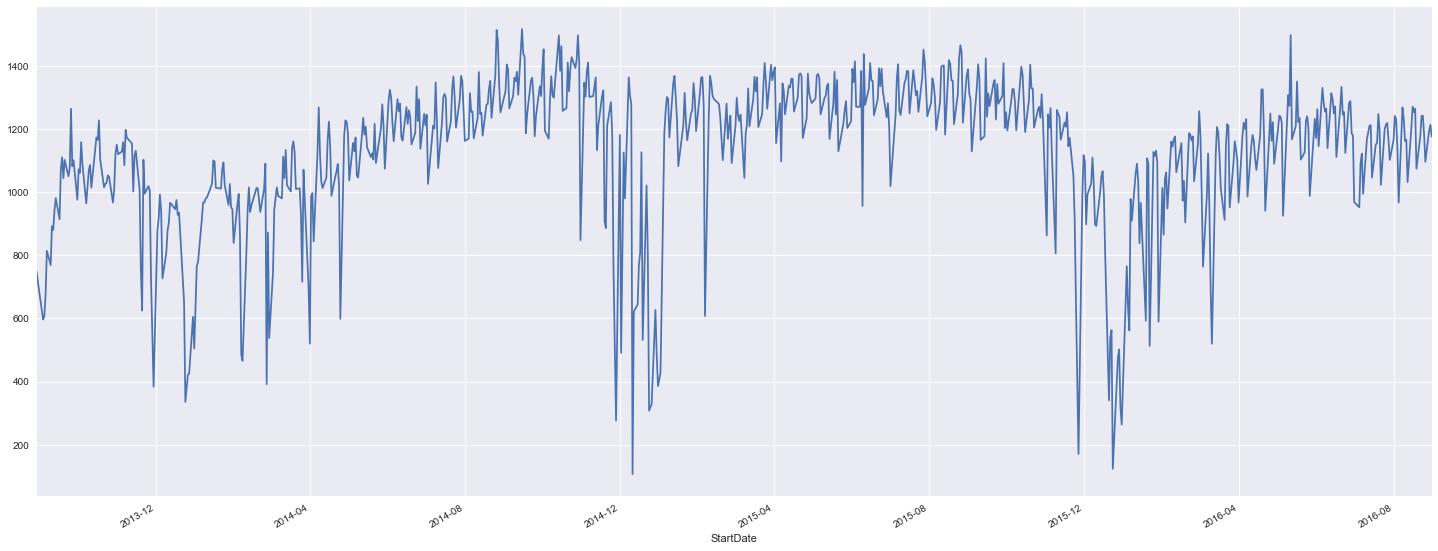

In [63]:
worktrips = trips.set_index('StartDate')
worktrips = worktrips.groupby(pd.TimeGrouper(freq = 'D')).size()
worktrips = worktrips[ worktrips.index.isin(holidays) == False ]
weekday = worktrips.index.weekday
worktrips = worktrips[weekday.isin([0,1,2,3,4])]
worktrips.plot(figsize = (25,10))
#worktrips[worktrips<800]

The plot seems to be less noisy when eliminate holidays and weekends. However, there are still some outliers.

## Usage per day from Subscriber on Weekdays

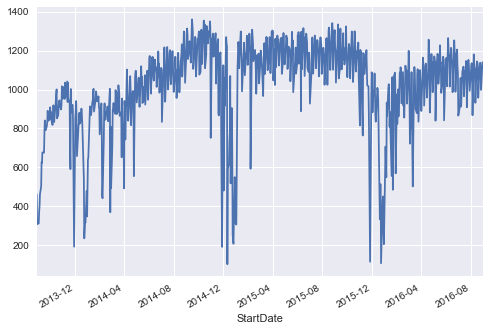

In [66]:
worktrips = trips[trips['SubscriptionType'] == 'Subscriber'].set_index('StartDate')
worktrips = worktrips.groupby(pd.TimeGrouper(freq = 'D')).size()
holiday = worktrips.index.isin(holidays)
worktrips = worktrips[ holiday == False ]
weekday = worktrips.index.weekday
worktrips = worktrips[weekday.isin([0,1,2,3,4])]
worktrips.plot()

## Usage per day from Customer

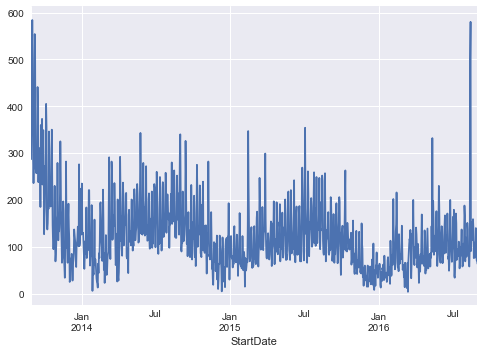

In [68]:
tripsc = trips[trips['SubscriptionType'] == 'Customer'].set_index('StartDate')
worktrips = tripsc.groupby(pd.TimeGrouper(freq = 'D')).size()
#holiday = worktrips.index.isin(holidays)
#worktrips = worktrips[ holiday == False ]
#weekday = worktrips.index.weekday
#worktrips = worktrips[weekday.isin([0,1,2,3,4])]
worktrips.plot()

## Hourly usage on weekday

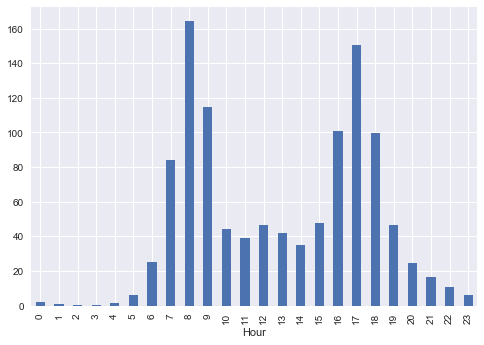

In [70]:
hourcounts = trips.set_index('StartDate')
hourcounts = hourcounts.groupby(pd.TimeGrouper(freq = 'h')).size()
holiday = hourcounts.index.isin(holidays)
worktrips = hourcounts[ holiday == False ]
weekday = hourcounts.index.weekday
hourcounts = hourcounts[weekday.isin([0,1,2,3,4])]
hourcounts = hourcounts.groupby(hourcounts.index.hour).mean()
hourcounts.index.name = 'Hour'
hourcounts.plot(kind = 'bar');

## Hourly usage on weekends and holidays

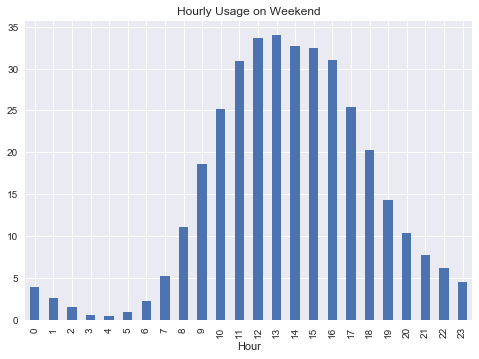

In [72]:
# Hourly usage on weekends and holidays
hourcounts = trips.set_index('StartDate')
hourcounts = hourcounts.groupby(pd.TimeGrouper(freq = 'h')).size()

holiday = hourcounts.index.isin(holidays)
weekday = hourcounts.index.weekday.isin([5,6])
hourcounts = hourcounts[weekday | holiday]
hourcounts = hourcounts.groupby(hourcounts.index.hour).mean()
hourcounts.index.name = 'Hour'
hourcounts.plot(title = 'Hourly Usage on Weekend', kind = 'bar');

# Analyze trips vs. weather

## Trips per day vs. Temperature

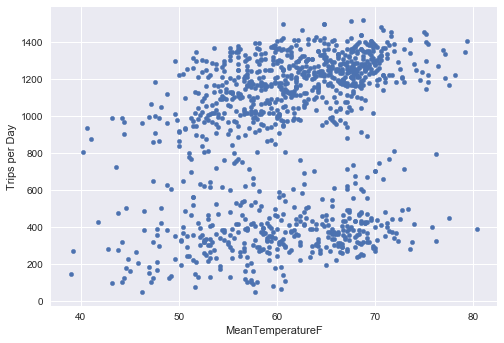

In [76]:
wt = weathers.groupby(['PDT'])['MeanTemperatureF'].mean().sort_index()
numTrip = trips.set_index('StartDate')
numTrip = numTrip.groupby(pd.TimeGrouper(freq = 'D')).size()
numTrip = numTrip.rename('Trips per Day')
numTriptoTemp = pd.concat([wt,numTrip], axis =1)
numTriptoTemp = numTriptoTemp.rename(index = str, columns = {"Day":"Trips per Day"})
numTriptoTemp.plot(x = 'MeanTemperatureF', y='Trips per Day', kind = 'scatter');

It seems there are two groups. The lower cluster could caused by holiday

## Trips in weekday vs. Temperature

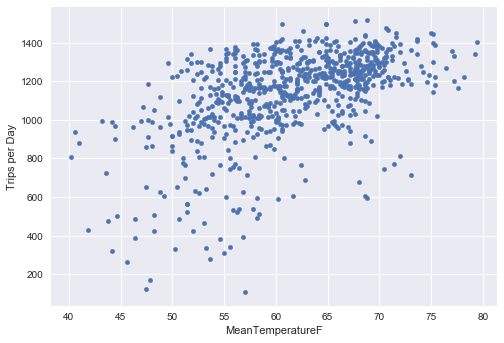

In [77]:
# Get trips counts per day
t = trips.set_index('StartDate')
t = t.groupby(pd.TimeGrouper(freq = 'D')).size()
t = t.rename('Trips per Day')
# Get data only from weekdays
t = pd.concat([t, wt], axis = 1)
holiday = t.index.isin(holidays)
weekday = t.index.weekday.isin([0,1,2,3,4])
t = t[weekday & (holiday == False)]

# Plot data
t.plot(x = 'MeanTemperatureF', y='Trips per Day', kind = 'scatter')

## Trips in weekend vs. Temperature

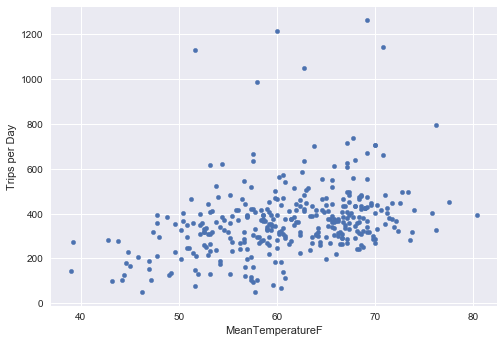

In [82]:
# Get trips counts per day
t = trips.set_index('StartDate')
t = t.groupby(pd.TimeGrouper(freq = 'D')).size()
t = t.rename('Trips per Day')

# Get data only from weekdays
t = pd.concat([t, wt], axis = 1)
holiday = t.index.isin(holidays)
weekend = t.index.weekday.isin([5,6])
t = t[weekend | holiday]

# Plot data
t.plot(x = 'MeanTemperatureF', y='Trips per Day', kind = 'scatter')

## Avg. Trips per day vs. Temperature

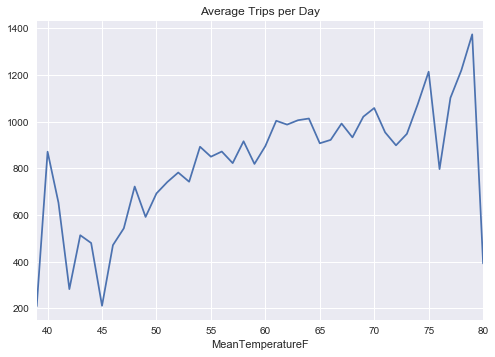

In [79]:
avgTriptoTemp = numTriptoTemp.groupby(numTriptoTemp['MeanTemperatureF']//1)['Trips per Day'].mean()
avgTriptoTemp.plot(title = 'Average Trips per Day');

This data could further exclude weekends and devide by location to have more accurate relationship

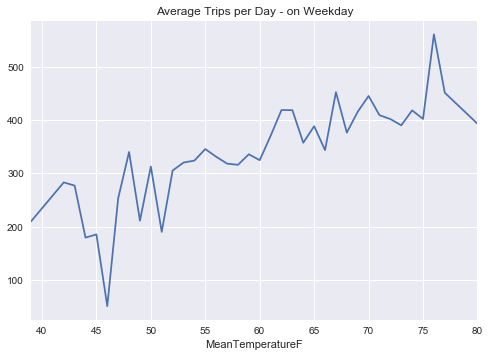

In [80]:
t = numTriptoTemp[weekday & (holiday == False)]
avgTriptoTemp = t.groupby(t['MeanTemperatureF']//1)['Trips per Day'].mean()
avgTriptoTemp.plot(title = 'Average Trips per Day - on Weekday')

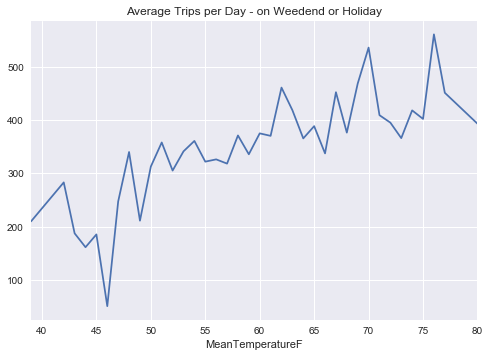

In [83]:
t = numTriptoTemp[weekend | holiday]
avgTriptoTemp = t.groupby(t['MeanTemperatureF']//1)['Trips per Day'].mean()
avgTriptoTemp.plot(title = 'Average Trips per Day - on Weedend or Holiday')

## Trips per day vs. Precipitation

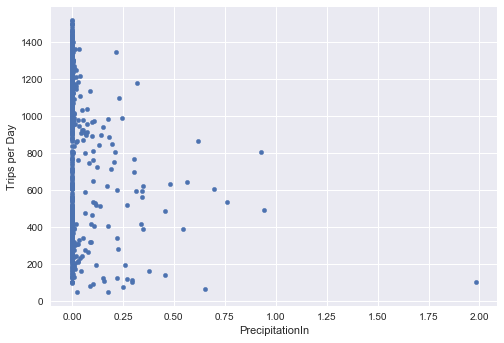

In [84]:
preci = weathers.groupby(['PDT'])['PrecipitationIn'].mean().sort_index()
numTriptoPreci = pd.concat([preci,numTrip], axis =1)
numTriptoPreci = numTriptoPreci.rename(index = str, columns = {"Day":"Trips per Day"} )
numTriptoPreci.plot(x = 'PrecipitationIn', y = 'Trips per Day', kind = 'scatter');


There's no obvious trend between trips and precipitation, probably due to the precipitation was focused in a particular area

# Trips per day vs. Station

## Avg. usage of a station per day

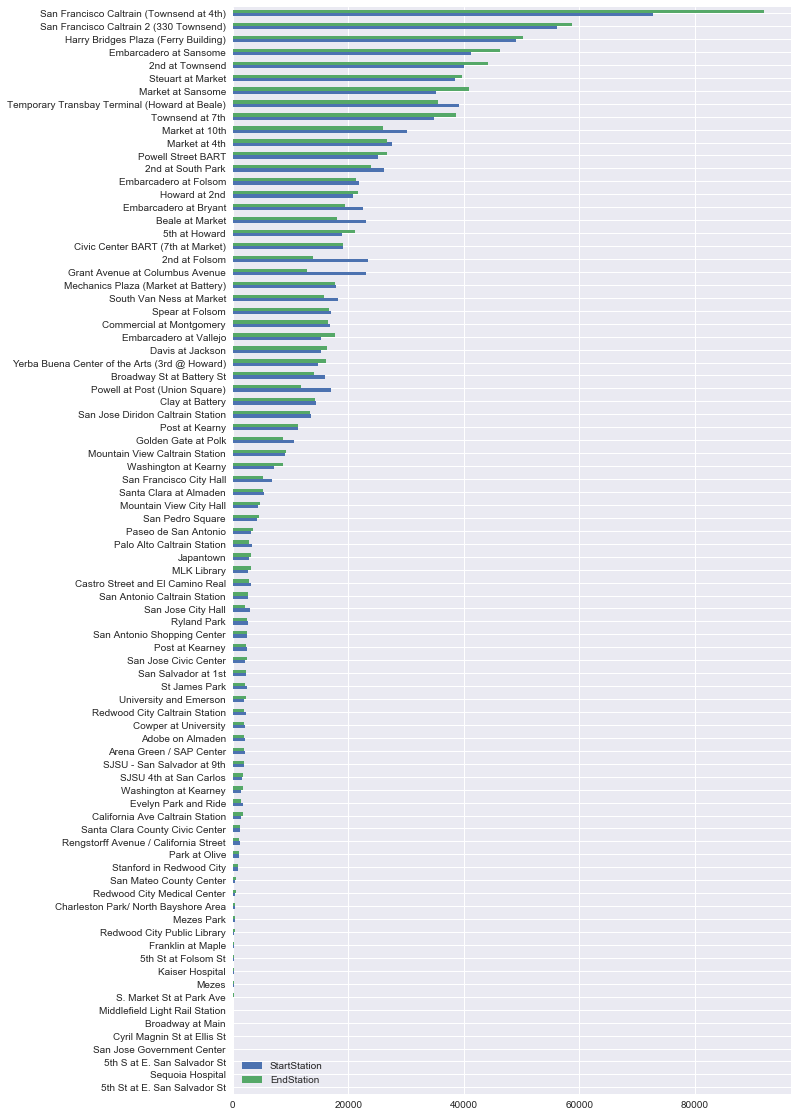

In [86]:
startStation = trips['StartStation']
startStation = startStation.value_counts().sort_index()
endStation = trips['EndStation']
endStation = endStation.value_counts().sort_index()
sumStation = (startStation+endStation).rename('Sum')
stationUsage = pd.concat([startStation, endStation, sumStation], axis = 1).sort_values(by = 'Sum')
stationUsage.iloc[:,:2].plot.barh(figsize=(10,20));

## Avg. hourly usage of a station per day

In [87]:
# Get the list of stations, sort from high to low usage
stationlist = sumStation.sort_values(ascending = False).index.tolist()

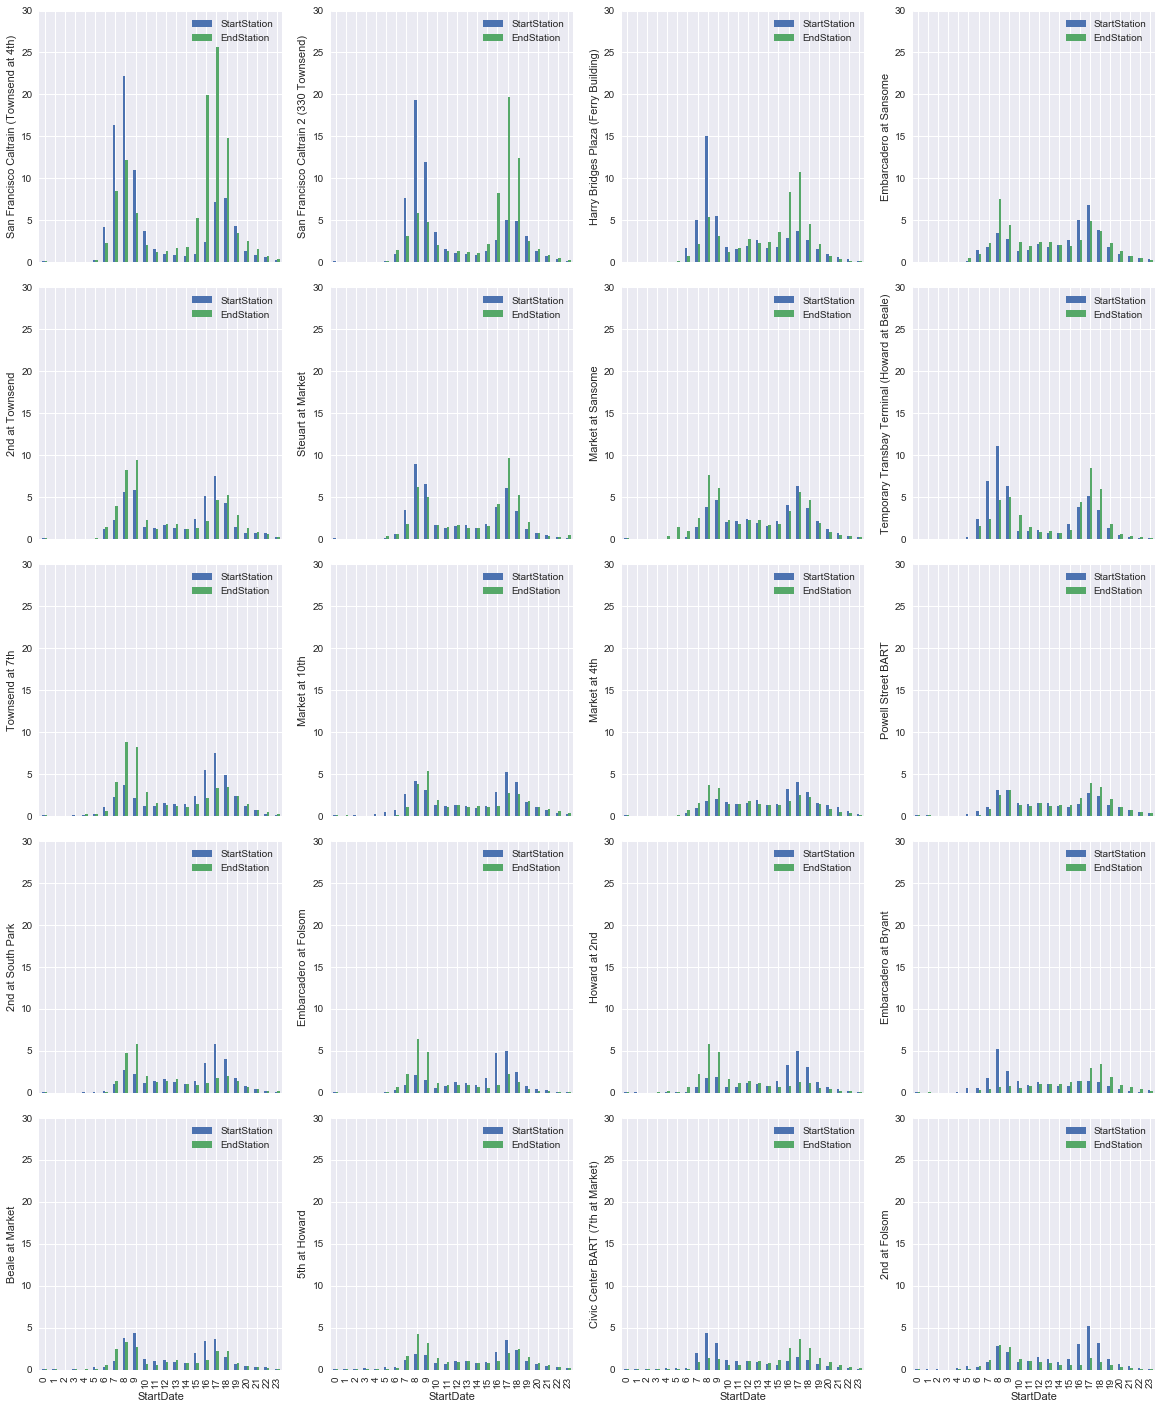

In [89]:
# Set plot parameters
# Plot only the top 20 usage stations
fig, axes = plt.subplots(5,4, figsize = (20,25))

for i, axs in enumerate(axes):
    for j, a in enumerate(axs):
        # Get hourly counts from Start Station (borrow bike)
        stationUsageS = trips[trips['StartStation'] == stationlist[i*4+j]]
        stationUsageS = stationUsageS.set_index('StartDate')
        stationUsageS = stationUsageS.groupby(pd.TimeGrouper(freq = 'H')).size()
        # Get hourly counts from End Station (return bike)
        stationUsageE = trips[trips['EndStation'] == stationlist[i*4+j]]
        stationUsageE = stationUsageE.set_index('EndDate')
        stationUsageE = stationUsageE.groupby(pd.TimeGrouper(freq = 'H')).size()
        # Rename and combine the two series
        stationUsageS = stationUsageS.rename('StartStation')
        stationUsageE = stationUsageE.rename('EndStation')
        stationUsage = pd.concat([stationUsageS, stationUsageE], axis = 1)
        # Exclued holidays and weekends
        holiday = stationUsage.index.isin(holidays)
        staitonUsage = stationUsage[holiday == False]
        weekday = stationUsage.index.weekday.isin([0,1,2,3,4])
        stationUsage = stationUsage[weekday]
        # Calculate average hourly usage by hour
        stationUsage = stationUsage.groupby(stationUsage.index.hour).mean()
        # Set plot parameters
        a.set_ylabel(stationlist[i*4+j])
        a = stationUsage.plot.bar(ax = a, sharex = 'Hour', ylim = (0,30))
        plt.subplots_adjust(hspace = 0.1)

## Empty and full status vs. time

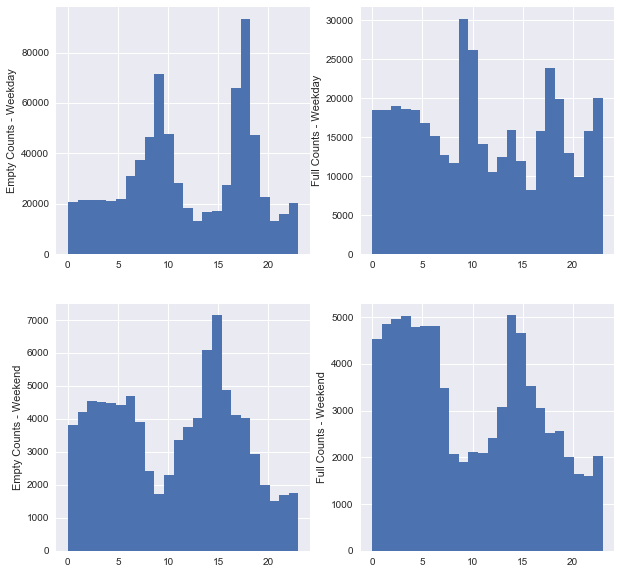

In [92]:
s = status
# Exclued holidays and weekends
holiday = s.time.isin(holidays)
weekday = s.time.dt.weekday.isin([0,1,2,3,4])
weekend = s.time.dt.weekday.isin([5,6])
sd = s[weekday & (holiday == False)]
se = s[weekend | holiday]
# Get Empty and Full data
sdEmpty = sd[sd.bikes_available == 0].hours
sdFull = sd[sd.docks_available == 0].hours
seEmpty = se[se.bikes_available == 0].hours
seFull = se[se.docks_available == 0].hours
# Plot
fig, axes = plt.subplots(2,2, figsize = (10,10));
sdEmpty.plot.hist(bins = 24, ax = axes[0][0]);
axes[0][0].set_ylabel('Empty Counts - Weekday');
sdFull.plot.hist(bins = 24, ax = axes[0][1]);
axes[0][1].set_ylabel('Full Counts - Weekday');
seEmpty.plot.hist(bins = 24, ax = axes[1][0]);
axes[1][0].set_ylabel('Empty Counts - Weekend');
seFull.plot.hist(bins = 24, ax = axes[1][1]);
axes[1][1].set_ylabel('Full Counts - Weekend');


Notice that there are certain drop at particular times in the weekend. It could be the Bike Share trying to move the bikes to evenly distribute the bikes.

## 10 most popular route

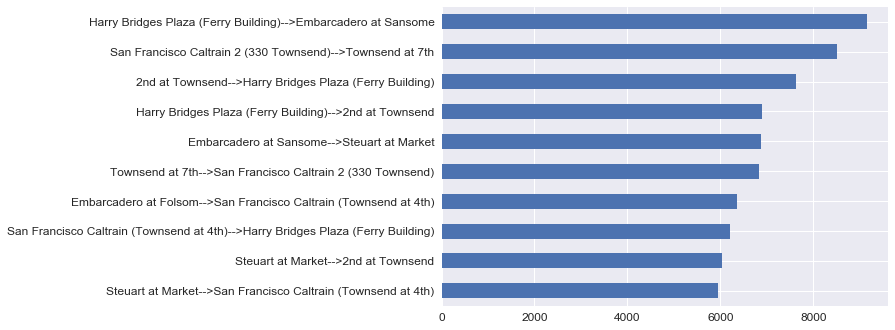

In [97]:
t = trips.set_index('StartDate')
route = t['StartStation'] +'-->' +t['EndStation']
t = t.assign(route=route)
t.route.value_counts()[:10].sort_values().plot.barh(fontsize = 12);

### 10 most popular route for subscriber

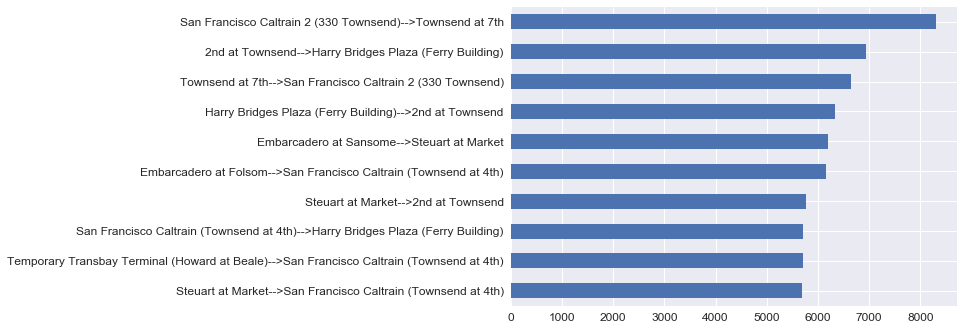

In [99]:
t = trips.set_index('StartDate')
t = t[t['SubscriptionType'] == 'Subscriber']
route = t['StartStation'] +'-->' +t['EndStation']
t = t.assign(route=route)
t.route.value_counts()[:10].sort_values().plot.barh(fontsize = 12);

### 10 most popular route for customer

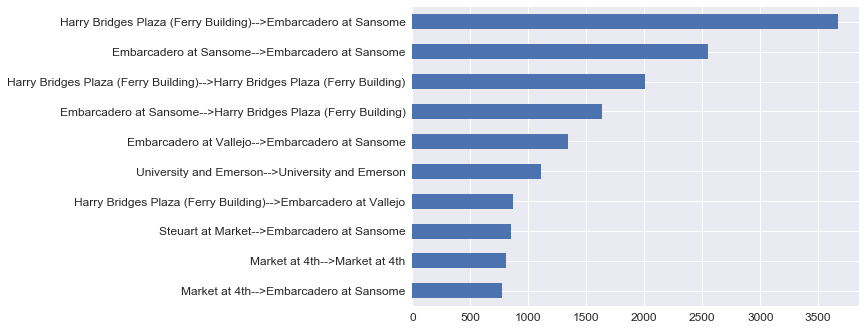

In [103]:
t = trips.set_index('StartDate')
t = t[t['SubscriptionType'] == 'Customer']
route = t['StartStation'] +'-->' +t['EndStation']
t = t.assign(route=route)
t.route.value_counts()[:10].sort_values().plot.barh(fontsize = 12);

### 10 most popular route in weekday

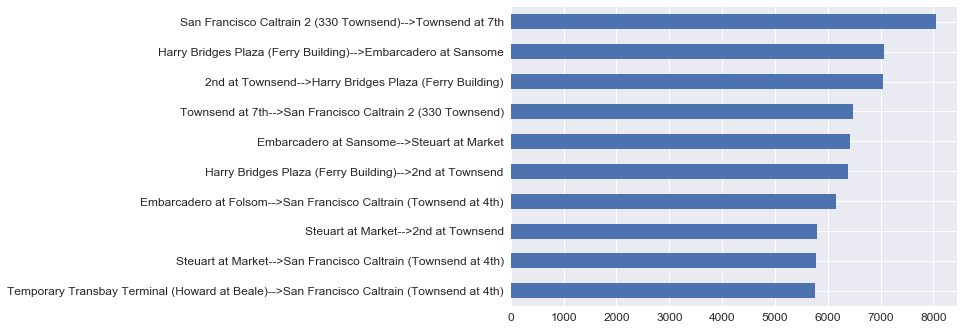

In [105]:
t = trips.set_index('StartDate')
holiday = t.index.isin(holidays)
weekday = t.index.weekday.isin([0,1,2,3,4])
t = t[weekday & (holiday == False)]
route = t['StartStation'] +'-->' +t['EndStation']
t = t.assign(route=route)
t.route.value_counts()[:10].sort_values().plot.barh(fontsize = 12);

### 10 most popular route in weekend

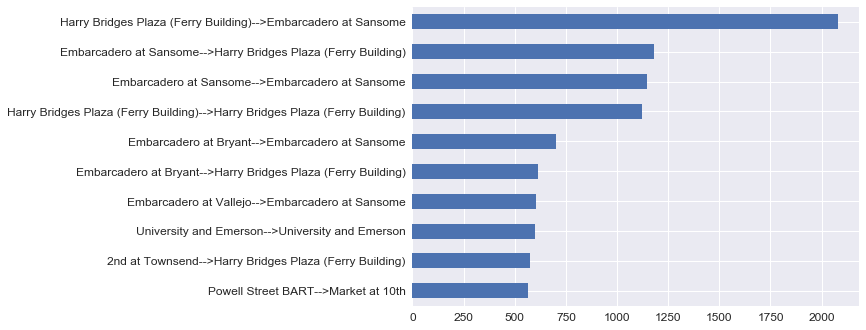

In [104]:
t = trips.set_index('StartDate')
holiday = t.index.isin(holidays)
weekend = t.index.weekday.isin([5,6])
t = t[weekend | holiday]
route = t['StartStation'] +'-->' +t['EndStation']
t = t.assign(route=route)
t.route.value_counts()[:10].sort_values().plot.barh(fontsize = 12);